In [4]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from combat.pycombat import pycombat
from scipy import stats
import statsmodels.stats.multitest as smm
import joblib
import networkx as nx
from matplotlib import cm
import seaborn as sns

dataset = pd.read_csv('../../Dataset/Merged/MergedDatasetZeroes.csv', index_col=0)
datasetID = dataset['SampleID'].apply(lambda x: x.split('-')[0]).values
labels = dataset['Label']
dataset = dataset.drop(columns=['SampleID', 'Label'])

data = pycombat(dataset.transpose(), datasetID).transpose()
data['Label'] = labels

Found 7 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.


C:\Users\samue\AppData\Roaming\Python\Python311\site-packages\combat\pycombat.py:159: RuntimeWarning: divide by zero encountered in divide
  np.absolute(d_new-d_old)/d_old))  # maximum difference between new and old estimate


Adjusting the Data


In [2]:
no_ms = data[data['Label'] == 0].drop(columns='Label')
ms = data[data['Label'] == 1].drop(columns='Label')

p_values = []
genes = ms.columns

for gene in genes:
    t_stat, p_val = stats.ttest_ind(no_ms[gene], ms[gene], equal_var=False)
    p_values.append(p_val)

# Correzione di Bonferroni
_, pvals_corrected, _, _ = smm.multipletests(p_values, alpha=0.05, method='bonferroni')

results = pd.DataFrame({
    'gene': genes,
    'p_value': p_values,
    'p_value_corrected': pvals_corrected
})

differentially_expressed_genes = results[results['p_value_corrected'] < 0.05]

print(differentially_expressed_genes)

            gene       p_value  p_value_corrected
246       SEMA4D  2.199244e-09       2.659107e-05
527     HLA-DRB1  1.810917e-10       2.189580e-06
724       PABPC1  1.408091e-12       1.702523e-08
1279      FAM50A  9.395489e-09       1.136009e-04
1723     ATP5MC3  9.297248e-10       1.124130e-05
2191     ZKSCAN8  1.007170e-08       1.217769e-04
2406      CUEDC2  2.929212e-06       3.541710e-02
2679     PSMC3IP  3.020926e-06       3.652602e-02
3356        RPL4  2.527204e-06       3.055643e-02
3668       SRP72  1.324817e-08       1.601836e-04
3941      DIAPH1  5.785612e-12       6.995384e-08
4301     RPL13.1  2.514136e-09       3.039842e-05
4337       RPS15  3.051227e-16       3.689238e-12
5067    HLA-DRB5  5.957709e-07       7.203466e-03
5132   MACROH2A1  1.476889e-16       1.785707e-12
5543        SAT1  2.524065e-06       3.051847e-02
5897      LRRC59  4.889482e-09       5.911873e-05
6533       TRMT5  7.027509e-21       8.496961e-17
6926      ZNHIT1  1.543747e-06       1.866544e-02


In [3]:
diff_gene = differentially_expressed_genes['gene'].values
print(diff_gene)

['SEMA4D' 'HLA-DRB1' 'PABPC1' 'FAM50A' 'ATP5MC3' 'ZKSCAN8' 'CUEDC2'
 'PSMC3IP' 'RPL4' 'SRP72' 'DIAPH1' 'RPL13.1' 'RPS15' 'HLA-DRB5'
 'MACROH2A1' 'SAT1' 'LRRC59' 'TRMT5' 'ZNHIT1' 'HNRNPA1' 'IL24' 'AKAP13'
 'ELOVL5' 'NDUFA10' 'UBR4' 'RPS28' 'LATS1' 'PSMB4' 'SPATA1' 'FTH1P5'
 'WIPI2']


In [4]:
expl_summary = joblib.load('../../ShapValues/DatasetZeroes/ensemble_summary.pkl')
ensemble_ablation = joblib.load("../../ShapValues/DatasetZeroes/ensembleSoft_ablationScores.pkl")
ensemble_featureSelected = joblib.load('../../ShapValues/DatasetZeroes/ensembleSoft_featureSelection.pkl')

Intersezione con migliori 100 LIME explanations

In [5]:
expl_best = list(dict(sorted(dict(zip(data.columns, expl_summary)).items(), key=lambda item: item[1], reverse=True)).keys())[:100]
resultExpl = set(differentially_expressed_genes['gene']).intersection(set(expl_best))
print(resultExpl)

{'HNRNPA1', 'HLA-DRB5', 'HLA-DRB1'}


Intersezione con migliori 100 SHAP ensemble ridotto

In [6]:
shap_object = joblib.load('../../ShapValues/DatasetZeroes/ensembleSelected_shapValues.pkl')
ensembleSelected = joblib.load('../../Modelli/DatasetZeroes/ensembleSelected_39.pkl')
shap_values = shap_object.values
shap_importance = np.abs(shap_values).mean(0)
shap_dict = dict(zip(ensembleSelected.feature_names_in_, shap_importance))
expl_dictSummary = dict(zip(ensembleSelected.feature_names_in_, shap_importance))
expl_sorted = dict(sorted(expl_dictSummary.items(), key=lambda item: item[1], reverse=True))

print(set(differentially_expressed_genes['gene']).intersection(set(list(expl_sorted.keys())[:100])))

{'HLA-DRB5', 'HNRNPA1', 'HLA-DRB1'}


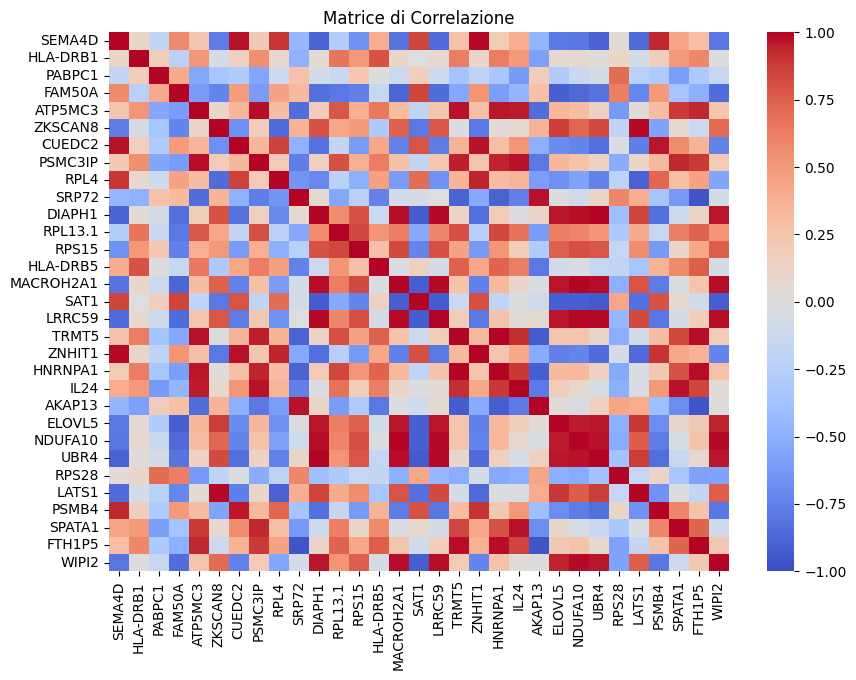

In [5]:
intersectCorr = dataset[differentially_expressed_genes['gene']].corr()

plt.figure(figsize=(10,7))
sns.heatmap(intersectCorr, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Matrice di Correlazione')
plt.show()

In [6]:
ensemble_correlated_pairs = np.where(np.abs(intersectCorr) >= 0.75)

# Print the correlated pairs
for i, j in zip(ensemble_correlated_pairs[0], ensemble_correlated_pairs[1]):
    if i != j:
        print(f"{intersectCorr.index[i]} - {intersectCorr.columns[j]}: {intersectCorr.iloc[i, j]}")

SEMA4D - ZKSCAN8: -0.7762474526224005
SEMA4D - CUEDC2: 0.9747926874254417
SEMA4D - RPL4: 0.8962274968046675
SEMA4D - DIAPH1: -0.8876440924422714
SEMA4D - MACROH2A1: -0.8195675947615655
SEMA4D - SAT1: 0.8496747558183523
SEMA4D - LRRC59: -0.8518905977052494
SEMA4D - ZNHIT1: 0.98442920078833
SEMA4D - ELOVL5: -0.7946903128600897
SEMA4D - NDUFA10: -0.8009192379043467
SEMA4D - UBR4: -0.9047040313234983
SEMA4D - LATS1: -0.8543174896695414
SEMA4D - PSMB4: 0.9366064866398004
SEMA4D - WIPI2: -0.8050364886396036
HLA-DRB1 - HLA-DRB5: 0.7994366396295313
FAM50A - DIAPH1: -0.8326461069039889
FAM50A - RPL13.1: -0.7910641322999963
FAM50A - RPS15: -0.7555980048098782
FAM50A - MACROH2A1: -0.8822770541088236
FAM50A - SAT1: 0.8471860119330841
FAM50A - LRRC59: -0.8564758124300477
FAM50A - ELOVL5: -0.9117525213823452
FAM50A - NDUFA10: -0.8650851914902471
FAM50A - UBR4: -0.8200568733265962
FAM50A - WIPI2: -0.8473703508989328
ATP5MC3 - PSMC3IP: 0.980374438200407
ATP5MC3 - SRP72: -0.8440697773244229
ATP5MC3 - R

C:\Users\samue\AppData\Local\Temp\ipykernel_30732\2513634623.py:30: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label="Coefficiente di Correlazione")


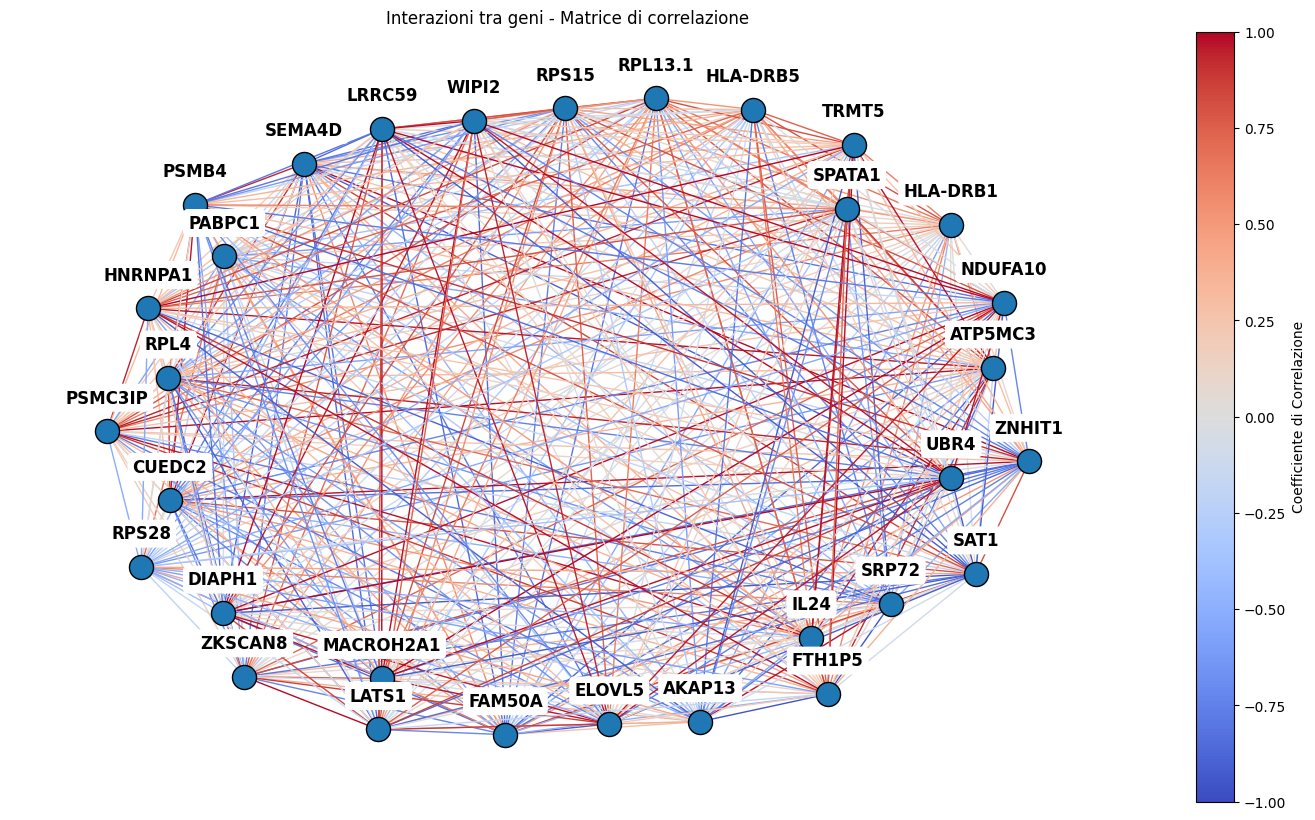

In [7]:
G = nx.Graph()

for i in range(intersectCorr.shape[0]):
    for j in range(intersectCorr.shape[1]):
        if i != j:
            G.add_edge(intersectCorr.columns[i], intersectCorr.columns[j], weight = intersectCorr.iloc[i, j])

weights = nx.get_edge_attributes(G, 'weight').values()
norm = plt.Normalize(-1, 1)
colors = [cm.coolwarm(norm(w)) for w in weights]

pos = nx.spring_layout(G, k=4)
fig, ax = plt.subplots(figsize=(18,10))

# Disegna i nodi con il contorno nero
nx.draw_networkx_nodes(G, pos, node_size=300, edgecolors='black', linewidths=1)

# Crea un offset per spostare le etichette sopra i nodi
label_pos = {node: (pos[node][0], pos[node][1] + 0.1) for node in G.nodes()}

# Disegna le etichette sopra i nodi
nx.draw_networkx_labels(G, label_pos, font_color='black', font_size=12, font_weight='bold', ax=ax, bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.3'))

# Disegna gli archi
nx.draw_networkx_edges(G, pos, ax=ax, edge_color=colors)

# Aggiungi la barra dei colori
sm = plt.cm.ScalarMappable(cmap=cm.coolwarm, norm=norm)
sm.set_array([])
plt.colorbar(sm, label="Coefficiente di Correlazione")
plt.title('Interazioni tra geni - Matrice di correlazione')
plt.axis('off')
plt.show()